# Voronoi Polygons to Determine Catchment Areas

Create Voronoi Polygons overlayed on a map to partition the customer base and determine the catchment area for each organization. Example code from JeffMyLife (https://github.com/jeffmylife/casual/blob/master/Voromap.ipynb) to show hospitals in the US with heliports and the geographic areas they service.

In [ ]:
!pip install scipy
!pip install geopandas

from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import folium 
from folium import vector_layers 
%matplotlib inline

In [ ]:
import random
def random_color(as_str=True, alpha=0.5):
    rgb = [random.randint(0,255),
           random.randint(0,255),
           random.randint(0,255)]
    if as_str:
        return "rgba"+str(tuple(rgb+[alpha]))
    else:
        return list(np.array(rgb)/255) + [alpha]
    

In [ ]:

def voronoi_finite_polygons_2d(vor, radius=None):
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max() * 2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def voronoi_polygons(n=50):
    random_seeds = np.random.rand(n, 2)
    vor = Voronoi(random_seeds)
    regions, vertices = voronoi_finite_polygons_2d(vor)
    polygons = []
    for reg in regions:
        polygon = vertices[reg]
        polygons.append(polygon)
    return polygons

In [ ]:
import geopandas
import pandas as pd

hospitals = pd.DataFrame(geopandas.read_file("Data/Hospitals.geojson"))

def is_level_one(x):
    """True if x is at least a level one trauma center, else False"""
    isin = ["LEVEL I,","LEVEL I ADULT","I, I "]
    iseq = ["1","I","LEVEL 1","LEVEL I","PARC"]
    return any([key in x for key in isin]) or any([key == x for key in iseq])

# Ensure data includes at least adult level I trauma hospitals 
hospitals = hospitals[hospitals["TRAUMA"].apply(is_level_one)]
hospitals = hospitals[list(hospitals["TYPE"]!="CHILDREN")]
hospitals = hospitals[~hospitals["NAME"].isin(["PRIMARY CHILDREN'S MEDICAL CENTER"])]

# Only interested in places w/ beds & a helipad 
hospitals = hospitals[~(hospitals["BEDS"]<=0).values]
hospitals = hospitals[hospitals["HELIPAD"]=="Y"]

# Remove hawaii bc it's far (sorry)
hospitals = hospitals[hospitals["STATE"]!="HI"] 

# Change to preferred col & index names
hospitals = hospitals.reset_index(drop=True)
hospitals = hospitals[["LONGITUDE", 'LATITUDE',"BEDS","STATE"]]
hospitals.columns = ["lon","lat","beds","state"] 
hospitals[["lon","lat","beds"]] = hospitals[["lon","lat","beds"]].astype(float)

hospitals.head(5)

In [ ]:
# Add Voronoi cell polygons 
def calc_polygons(df):
    vor = Voronoi(df[["lon","lat"]].values)
    regions, vertices = voronoi_finite_polygons_2d(vor)
    polygons = []
    for reg in regions:
        polygon = vertices[reg]
        polygons.append(polygon)
    return polygons
hospitals["polygons"] = calc_polygons(hospitals)
hospitals.head(5)

In [ ]:
import matplotlib as mpl
import matplotlib.cm as cm

def nums_to_color(series, cmap=cm.coolwarm_r, alpha=0.5):
    """
    See https://matplotlib.org/examples/color/colormaps_reference.html 
    for colormap names. 
    """
    
    norm = mpl.colors.Normalize(vmin=series.min(), 
                                vmax=series.max())
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    m_arr = m.to_rgba(series).reshape(len(series),4) * 255
    m_arr[:,3] = np.repeat(alpha, len(series))
    return list(m_arr)

hospitals["colors"] = nums_to_color(hospitals["beds"], alpha=0.9)
hospitals.head(5)

In [ ]:
hospitals.sort_values("beds").head(5)

In [ ]:
import math
def to_convex(points):
    # compute centroid
    cent = (sum([p[0] for p in points])/len(points),
            sum([p[1] for p in points])/len(points))
    # sort by polar angle
    points.sort(key=lambda p: math.atan2(p[1] - cent[1],
                                         p[0] - cent[0]))
    return points

In [ ]:
from PIL import Image, ImageChops
import io
from IPython.display import Image as Image_Display
from os import remove as Remove


def trim(im):
    """src: https://stackoverflow.com/questions/10615901/trim-whitespace-using-pil """
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

def show_map(m):
    """Must show folium maps as inline png to show on GitHub"""
    stream = io.BytesIO(m._to_png())
    img = Image.open(stream)
    
    # trim bc sometimes the folium.to_png() can generate whitespace 
    img = trim(img)
    
    # save instead of matplotlib.pyplot.imshow(np.array(img)) bc better quality
    img.save("m.png")
    png = Image_Display(filename='m.png')
    
    # clean up
    Remove("m.png")
    return png


In [ ]:
from folium.features import DivIcon

def plot_map(df, center=(39.8283, -98.5795), show_nums=False, show_seeds=True):
    m = folium.Map(location=[*center],
                   width=750, height=500, 
                   zoom_start=4,
                   api_key='6NbtVc32EkZBkf8eXLAE')
    
    for lat, lon, color, poly, beds in df[["lat","lon","colors","polygons","beds"]].values:
        points = to_convex(np.flip(poly).tolist())
        vlayer = vector_layers.Polygon(points, 
                                       fill=True, 
                                       color="black",
                                       fill_color="rgba({}, {}, {}, {})".format(*color),
                                       weight=1)
        m.add_child(vlayer)

        if show_seeds:
            clayer = vector_layers.Circle([lat,lon], 2, color="black")
            m.add_child(clayer)
        
        if show_nums:
            folium.Marker((lat, lon), icon=DivIcon(
            icon_size=(.1,.1),
            icon_anchor=(6,19),
            html='<div style="font-size: 5pt; color : black">%s</div>'%str(int(beds)),
            )).add_to(m)
        
    return m

show_map(plot_map(hospitals))

### ^^ blue --> more beds ;; red --> less beds ^^ 



## Clustering nearby hospitals 
<br>
The diagram above looks somewhat redundant at hospital-dense cities. So, a density-based clustering alg (DBSCAN) should soften the diagram. Doing this is mainly for aesthetic purposes. In case you're worried, the clustering does sum the beds of clustered hospitals into the new combined cell. 

In [28]:
hosps = hospitals.copy()[["lat","lon","beds"]]

In [29]:
from sklearn.cluster import DBSCAN

def cluster(df, eps=0.5):
    # Get data
    df = df.copy()
    X = df[["lon","lat"]].values
    
    # Compute DBSCAN
    db = DBSCAN(eps=eps, min_samples=1).fit(X)
    
    # Temporarily add cluster labels to df
    df["cluster"] = db.labels_
    clustered_data = []
    for cluster in set(db.labels_):
        values = df[df["cluster"]==cluster].values
        beds = values[:,2].sum()
        center = values[:,0:2].mean(axis=0)
        clustered_data.append({"lat":center[0],
                               "lon":center[1],
                               "beds":beds})
    return pd.DataFrame(clustered_data)

clustered_hospitals = cluster( hosps , eps=0.25)

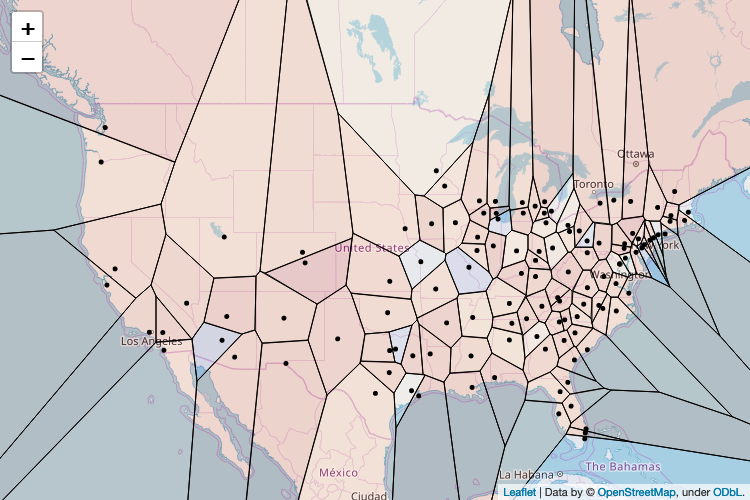

In [67]:

clustered_hospitals["colors"] = nums_to_color(clustered_hospitals["beds"], alpha=0.8)
clustered_hospitals["polygons"] = calc_polygons(clustered_hospitals)

show_map(plot_map(clustered_hospitals, show_nums=False))

## Heat Mapsum could do so enjoy random plots on the same data. 

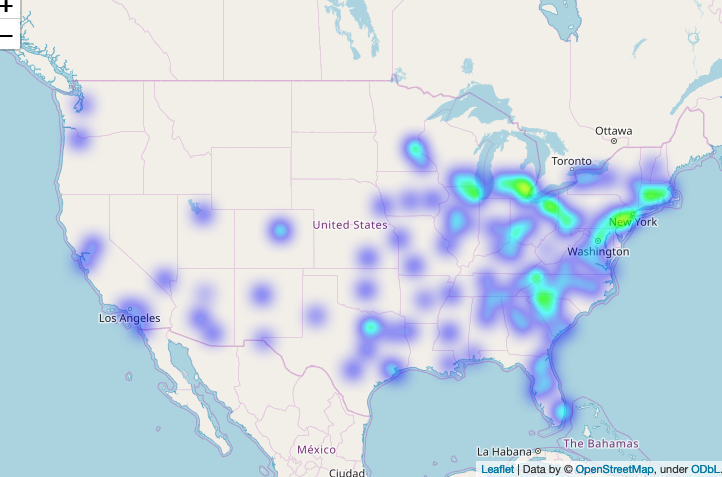

In [68]:
from folium.plugins import HeatMap

center=(39.8283, -98.5795)
m = folium.Map(location=[*center],
                   width=750, height=500, 
                   zoom_start=4,
                   api_key='6NbtVc32EkZBkf8eXLAE')
HeatMap(data=hospitals[["lat","lon","beds"]].values, radius=8, max_zoom=13).add_to(m)
show_map(m)